In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
prob_f = pd.DataFrame({'Fire': ['T', 'F'], 
                       'proba': [0.01, 0.99]})
prob_aGf = pd.DataFrame({'Fire': ['T', 'T', 'F', 'F'], 
                         'Alarm': ['T', 'F', 'T', 'F'], 
                         'proba': [0.95, 0.05, 0.01, 0.99]})
utility_matrix = pd.DataFrame({'Fire': ['T', 'T', 'T', 'T', 'F', 'F', 'F', 'F'], 
                        'checkSmoke': ['T', 'T', 'F', 'F', 'T', 'T', 'F', 'F'], 
                        'Call': ['T', 'F', 'T', 'F', 'T', 'F', 'T', 'F'],
                        'Utility': [-220, -5020, -200, -5000, -220, -20, -200, 0,],})

### Problem 2.1

In [3]:
# Merge probability values for the Fire and Alarm - if Alarm True then checkSmoke is True 
X1 = pd.merge(left=prob_aGf, right=prob_f, on=['Fire'])
X1['proba'] = X1['proba_x'] * X1['proba_y']
X1 = X1[['Fire', 'Alarm', 'proba']]

In [4]:
# Sum out the Fire chance node, it isn't a parent of any decision nodes (i.e. checkSmoke, call) 
X2 = pd.merge(left=X1, right=utility_matrix, on=['Fire'])
X2['weighted_utility'] = X2['Utility'] * X2['proba']
X2 = X2[['Alarm', 'Fire', 'checkSmoke', 'Call', 'weighted_utility']]

In [5]:
joint_factor = X2.groupby(['Alarm', 'checkSmoke', 'Call'])[['weighted_utility']].sum().reset_index()
display(joint_factor)

,Alarm,checkSmoke,Call,weighted_utility
0,F,F,F,-2.500
1,F,F,T,-196.120
2,F,T,F,-22.112
3,F,T,T,-215.732
4,T,F,F,-47.500
5,T,F,T,-3.880
6,T,T,F,-47.888
7,T,T,T,-4.268


### Problem 2.2

In [6]:
# Retrieve the optimal policy and corresponding expected utilities for Call
joint_factor.loc[joint_factor.groupby(['Alarm', 'checkSmoke'])[['weighted_utility']].idxmax().values.flatten()]

,Alarm,checkSmoke,Call,weighted_utility
0,F,F,F,-2.500
2,F,T,F,-22.112
5,T,F,T,-3.880
7,T,T,T,-4.268


### Problem 2.4

In [7]:
display(joint_factor.loc[joint_factor.groupby(['Alarm'])[['weighted_utility']].idxmax().values.flatten()])
meu = joint_factor.loc[joint_factor.groupby(['Alarm'])[['weighted_utility']].idxmax().values.flatten()]['weighted_utility'].sum()
print(f'MEU:{meu}')

,Alarm,checkSmoke,Call,weighted_utility
0,F,F,F,-2.50
5,T,F,T,-3.88


MEU:-6.38


### Problem 3.3

In [8]:
prob_x1y = pd.DataFrame({'X1': [-1, 0, 1, -1, 0, 1], 'Y': [0, 0, 0, 1, 1, 1], 'proba': [0, 0.5, 0.5, 0.25, 0.5, 0.25]})
prob_x2y = pd.DataFrame({'X2': [-1, 0, 1, -1, 0, 1], 'Y': [0, 0, 0, 1, 1, 1], 'proba': [0.5, 0, 0.5, 0, 0.25, 0.75]})

In [9]:
samples = [(1, -1 , 0), (1, 1, 0), (0, -1, 0), (0, 1, 0), (1, 1, 1), (0, 0, 1), (0, 1, 1), (-1, 1, 1),]

In [10]:
tracker = []

for i in samples:
    x1, x2, x = i    
    
    # compute both the Y=0, Y=1 vector for each condtional probability
    t1 = prob_x1y[(prob_x1y['X1'] == x1) & (prob_x1y['Y'] == 0)]['proba'].values * prob_x2y[(prob_x2y['X2'] == x2) & (prob_x2y['Y'] == 0)]['proba'].values
    t2 = prob_x1y[(prob_x1y['X1'] == x1) & (prob_x1y['Y'] == 1)]['proba'].values * prob_x2y[(prob_x2y['X2'] == x2) & (prob_x2y['Y'] == 1)]['proba'].values
    
    if x == 0:
        tracker.append((t1/(t2+t1))[0])
    else:
        tracker.append((t2/(t2+t1))[0])

In [11]:
expected_counts = pd.DataFrame({'Pr(X1X2|Y)': tracker})
expected_counts = expected_counts.join(pd.DataFrame(samples, columns=['X1', 'X2', 'Y']))

In [12]:
expected_counts

,Pr(X1X2|Y),X1,X2,Y
0,1.000000,1,-1,0
1,0.571429,1,1,0
2,1.000000,0,-1,0
3,0.400000,0,1,0
4,0.428571,1,1,1
5,1.000000,0,0,1
6,0.600000,0,1,1
7,1.000000,-1,1,1


### Problem 3.4

In [13]:
maximization = expected_counts.copy()

In [14]:
maximization

,Pr(X1X2|Y),X1,X2,Y
0,1.000000,1,-1,0
1,0.571429,1,1,0
2,1.000000,0,-1,0
3,0.400000,0,1,0
4,0.428571,1,1,1
5,1.000000,0,0,1
6,0.600000,0,1,1
7,1.000000,-1,1,1


In [15]:
# normalize the aggregate weighted sum
pY = maximization.groupby('Y')[['Pr(X1X2|Y)']].sum()
pY = pY / pY.sum()
pY.columns = ['P(Y)']
display(pY)

,P(Y)
Y,
0,0.495238
1,0.504762


In [16]:
# normalize the marginal distribution for X1 given Y
new_prob_x1y = maximization.groupby(['Y', 'X1'])[['Pr(X1X2|Y)']].sum().reset_index()
new_prob_x1y = pd.pivot_table(data=new_prob_x1y, columns='X1', index='Y', values='Pr(X1X2|Y)').fillna(0)
new_prob_x1y = new_prob_x1y.apply(lambda x: x / x.sum(), axis=1)
display(new_prob_x1y)

X1,-1,0,1
Y,,,
0,0.000000,0.471154,0.528846
1,0.330189,0.528302,0.141509


In [17]:
# normalize the marginal distribution for X2 given Y
new_prob_x2y = maximization.groupby(['Y', 'X2'])[['Pr(X1X2|Y)']].sum().reset_index()
new_prob_x2y = pd.pivot_table(data=new_prob_x2y, columns='X2', index='Y', values='Pr(X1X2|Y)').fillna(0)
new_prob_x2y = new_prob_x2y.apply(lambda x: x / x.sum(), axis=1)
display(new_prob_x2y)

X2,-1,0,1
Y,,,
0,0.673077,0.000000,0.326923
1,0.000000,0.330189,0.669811


### Problem 4.1

In [18]:
# Drop samples 4 and 5 from the original 8 sample list
new_sample = pd.DataFrame(samples, columns=['X1', 'X2', 'Y'], index=np.arange(1, 9)).drop(index=[4, 5])

In [19]:
def activation_function1(val:float):
    "Denote the treatment given a f_w value"
    if val <= 0:
        return 0
    else:
        return 1

In [20]:
weightV = np.array([1, -2, 0])
alpha = 1

for w in new_sample.index:
    _x1, _x2, _y0 = new_sample.loc[w].values
    y_pred = activation_function1(weightV[0] + weightV[1]*_x1 + weightV[2]*_x2) 
    
    if (_y0-y_pred) == 0:
        print(f'Sampling {(_x1, _x2)} No weight updated occured')
    else:
        old_weight = weightV
        weightV += alpha*(_y0-y_pred)*np.array([1, _x1, _x2]) 
        print(f'Sampling {(_x1, _x2)} Weight update occured')
        print(f'\t{old_weight} -> {weightV}')

Sampling (1, -1) No weight updated occured
Sampling (1, 1) No weight updated occured
Sampling (0, -1) Weight update occured
	[ 0 -2  1] -> [ 0 -2  1]
Sampling (0, 0) Weight update occured
	[ 1 -2  1] -> [ 1 -2  1]
Sampling (0, 1) No weight updated occured
Sampling (-1, 1) No weight updated occured


### Problem 4.2

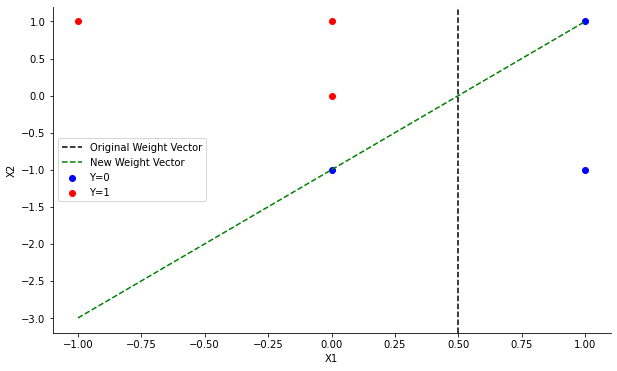

In [21]:
fig, axe = plt.subplots()

axe.spines[['right', 'top']].set_visible(False)
fig.set_figwidth(10)
fig.set_figheight(6)

plt.scatter(x=new_sample[new_sample['Y'] == 0].X1, y=new_sample[new_sample['Y'] == 0].X2, label='Y=0', color='b')
plt.scatter(x=new_sample[new_sample['Y'] == 1].X1, y=new_sample[new_sample['Y'] == 1].X2, label='Y=1', color='r')

# plot the intial weight vector denoted as (1, -2, 0) -> 1 - 2x = 0
axe.axvline(x=0.5, ls='--', color='k', label='Original Weight Vector')

# plot the intial weight vector denoted as (1, -2, 1) -> 1 - 2x + y = 0
axe.plot(np.arange(-1, 1.1, step=0.1), 2*np.arange(-1, 1.1, step=0.1)-1, ls='--', color='g', label='New Weight Vector')

axe.set_ylabel('X2')
axe.set_xlabel('X1')
plt.legend()
plt.show()

### Problem 4.3

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(new_sample[['X1', 'X2']], new_sample['Y'], test_size=0.1)

classifier = LogisticRegression().fit(X_train, y_train)
print("w0 =", classifier.intercept_)
print("[w1, w2] =", classifier.coef_)
print("test accuracy: ", classifier.score(X_test, y_test))

w0 = [-0.28535145]
[w1, w2] = [[-0.80046508  0.43929907]]
test accuracy:  1.0


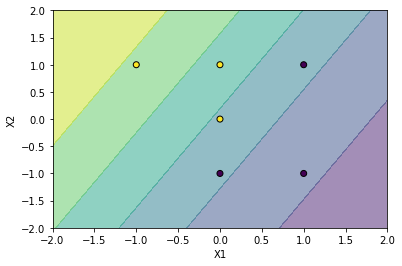

In [24]:
disp = DecisionBoundaryDisplay.from_estimator(
    classifier, new_sample[['X1', 'X2']], response_method="predict_proba", 
    xlabel='X1', ylabel='X2',
    alpha=0.5)
disp.ax_.scatter(new_sample['X1'], new_sample['X2'], c=new_sample['Y'], edgecolor="k")
plt.show()

### Problem 4.4

In [25]:
# compute the mean negative log likelihood
neg_log_likelihood = classifier.predict_log_proba(new_sample[['X1', 'X2']])
print(f'Mean negative log-likelihood: {np.mean(neg_log_likelihood)}')

Mean negative log-likelihood: -0.7772795038577506


In [26]:
# computing the gradient, defined by the partial deriviates of L with weight w_i
sk_wgt_vector = np.concatenate((classifier.intercept_,classifier.coef_[0]))

In [27]:
def sigmoid_func(x: list, wgt_vector:np.ndarray) -> float:
    val = 1 + np.exp(-(-wgt_vector[0] + wgt_vector[1]*x[0] + wgt_vector[2]*x[1]))
    return 1 / val 

In [28]:
# construct the error residual to be used in comptuation
error_res = []
for i in new_sample[['X1', 'X2']].index:
    error_res.append(sigmoid_func(new_sample.loc[i].values[:2], sk_wgt_vector))

In [29]:
for idx in range(3):
    avg_gradient = []
    
    for idx2, e in enumerate(error_res):    
        if idx == 0:
            avg_gradient.append(e * 1)
        else:
            avg_gradient.append(e * new_sample[['X1', 'X2']].iloc[idx2].iloc[idx-1])
        
    print(f'w_{idx} = {np.mean(avg_gradient)}')

w_0 = 0.5477368581017065
w_1 = -0.010372807971608352
w_2 = 0.2060648431836709
